In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from etl import preprocess_localiza_data

In [57]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

In [58]:
data = preprocess_localiza_data(carros_csv= "data/carros.csv", vendas_csv="data/vendas.csv")
data

,modelo,genero,idade,tempo_no_estoque,kilometragem,valor_a_vista,desconto_percentual,valor_parcela,qt_parcelas,recomprador,carro_na_troca,comprou_na_cidade_que_mora,marca,carroceria,preco_padrao
0,29,M,48,123,28840,0.0,0.09,0.0,1,0,0,1,F,HATCH,63821.0
1,95,M,44,83,37232,0.0,0.09,0.0,1,1,1,0,T,SEDAN,134857.0
2,6,M,35,77,44689,57218.0,0.07,180043.0,24,1,0,0,C,SUV,83654.0
3,13,M,33,103,42826,0.0,0.07,0.0,1,1,0,1,D,HATCH,76685.0
4,105,F,40,127,40315,87651.0,0.05,178237.0,48,1,1,1,G,SUV,124467.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76387,110,M,52,23,68157,84041.0,0.09,93152.0,36,0,1,1,J,SUV,98860.0
76388,93,F,41,5,40095,10120.0,0.09,189985.0,48,0,0,1,V,SEDAN,63682.0
76389,41,F,55,34,34860,20000.0,0.09,208363.0,48,1,0,0,G,SEDAN,78173.0
76390,95,M,43,105,32980,0.0,0.09,0.0,1,1,1,0,T,SEDAN,134857.0


## Processing

Coloquei uma lista de variáveis categóricas e númericas em duas listas separadas.

No ColumnTransformer, eu apliquei a transformação OneHotEnconder que transforma variáveis categóricas em booleanas e padronizei todas as variáveis númericas para terem a mesma média e variância.

In [59]:

categorical_cols = data.select_dtypes(["object", "category"]).columns
numerical_cols = data.select_dtypes(["number"]).columns


In [60]:

col_trans = ColumnTransformer(
        [
            ("ohe", OneHotEncoder(sparse_output=False), categorical_cols),
            ("scaler", StandardScaler(), numerical_cols)
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
        force_int_remainder_cols=False
    ).set_output(transform="pandas")

## PCA

PCA vai ajudar na hora de mostrar os clusters já que este método reduz o número de dimensões de um dataset 

In [61]:
pca = PCA(n_components=3)

In [62]:
pca_pipe = make_pipeline(
    col_trans,
    pca
).fit_transform(data)

## K-Means



In [63]:
kmeans = KMeans(
    n_clusters=4,
    random_state=2,
    n_init=20
)

kmeans_pipe = make_pipeline(
    col_trans, kmeans
)

kmeans_pipe.fit(data)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(sparse_output=False),
                                                  Index(['modelo', 'genero', 'marca', 'carroceria'], dtype='object')),
                                                 ('scaler', StandardScaler(),
                                                  Index(['idade', 'tempo_no_estoque', 'kilometragem', 'valor_a_vista',
       'desconto_percentual', 'valor_parcela', 'qt_parcelas', 'recomprador',
       'carro_na_troca', 'comprou_na_cidade_que_mora', 'preco_padrao'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kmeans', KMeans(n_clusters=4, n_init=20, random_state=2))])

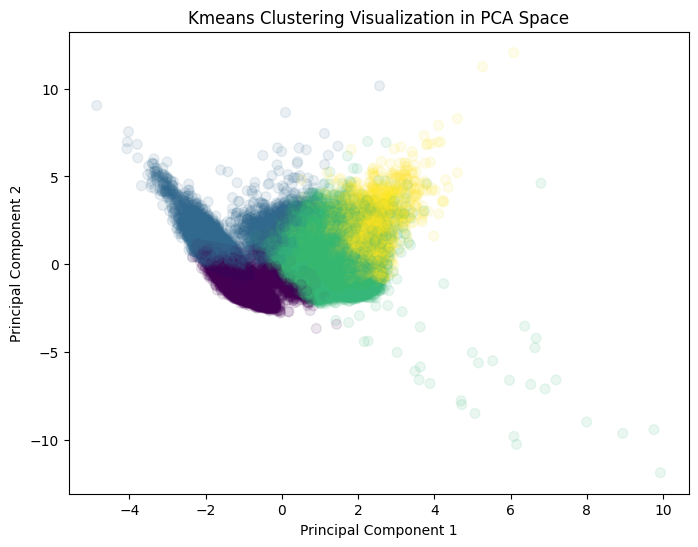

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_pipe[:, 0], pca_pipe[:, 1], c=kmeans_pipe["kmeans"].labels_ ,cmap='viridis', s=50, alpha=0.1)
plt.title('Kmeans Clustering Visualization in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2') 
plt.show()

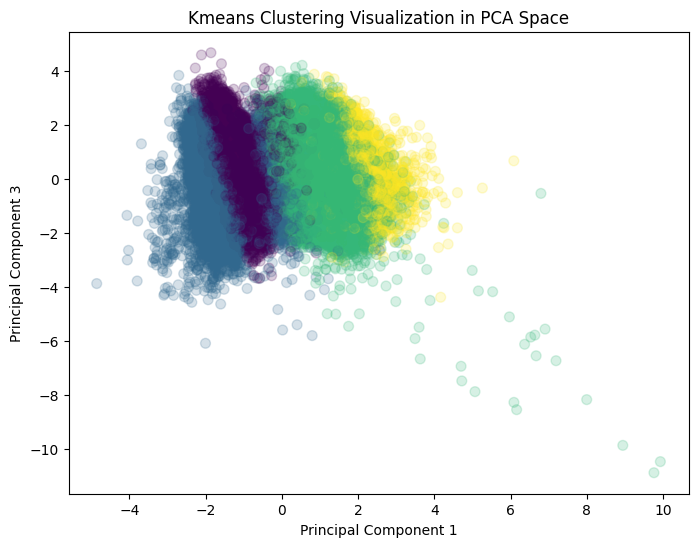

In [65]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_pipe[:, 0], pca_pipe[:, 2], c=kmeans_pipe["kmeans"].labels_, cmap='viridis', s=50, alpha=0.2)
plt.title('Kmeans Clustering Visualization in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3') 
plt.show()

## Hierarchical Clustering

In [66]:
data_sample = data.sample(25_000, random_state=2)

In [67]:
hclust = AgglomerativeClustering(
    distance_threshold=None,
    n_clusters=4,
    linkage="ward"
)

In [68]:
hclust_pipe = make_pipeline(
    col_trans, hclust
).fit(data_sample)

In [69]:
hclust_pca = make_pipeline(
    col_trans, pca
).fit_transform(data_sample)

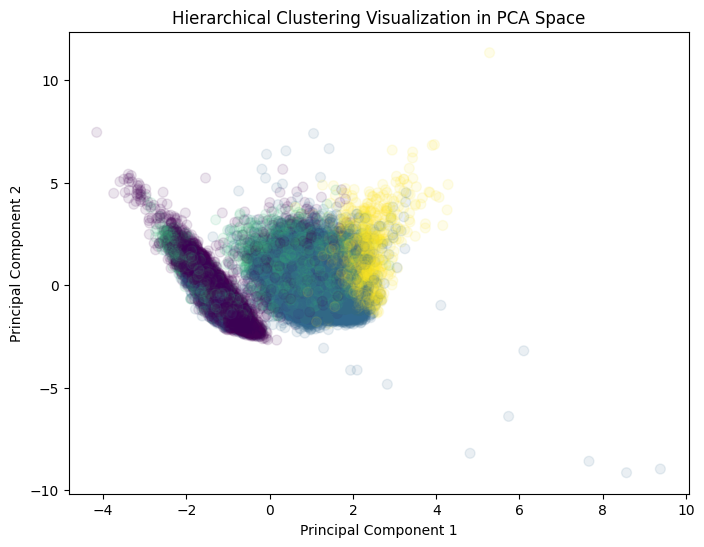

In [70]:
plt.figure(figsize=(8, 6))
plt.scatter(hclust_pca[:, 0], hclust_pca[:, 1], c=hclust_pipe["agglomerativeclustering"].labels_ ,cmap='viridis', s=50, alpha=0.1)
plt.title('Hierarchical Clustering Visualization in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2') 
plt.show()

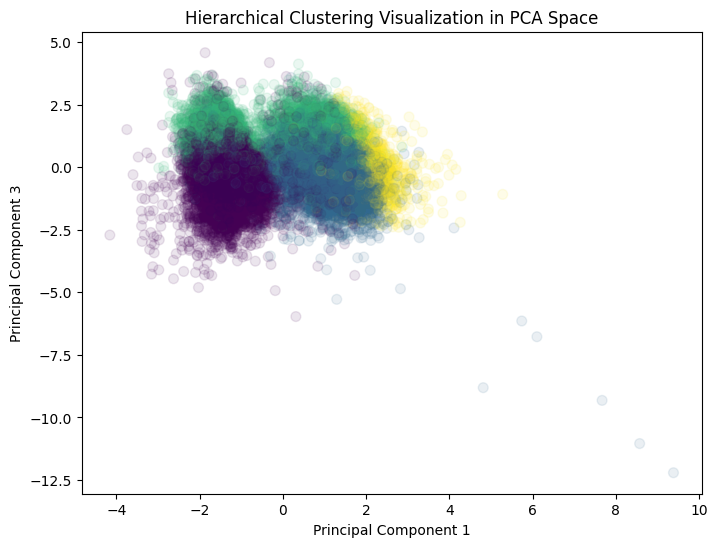

In [71]:
plt.figure(figsize=(8, 6))
plt.scatter(hclust_pca[:, 0], hclust_pca[:, 2], c=hclust_pipe["agglomerativeclustering"].labels_ ,cmap='viridis', s=50, alpha=0.1)
plt.title('Hierarchical Clustering Visualization in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3') 
plt.show()